In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [3]:
MORSE_CODE_DICT = { 'A':'.-', 'B':'-...', 
                    'C':'-.-.', 'D':'-..', 'E':'.', 
                    'F':'..-.', 'G':'--.', 'H':'....', 
                    'I':'..', 'J':'.---', 'K':'-.-', 
                    'L':'.-..', 'M':'--', 'N':'-.', 
                    'O':'---', 'P':'.--.', 'Q':'--.-', 
                    'R':'.-.', 'S':'...', 'T':'-', 
                    'U':'..-', 'V':'...-', 'W':'.--', 
                    'X':'-..-', 'Y':'-.--', 'Z':'--..', 
                    '1':'.----', '2':'..---', '3':'...--', 
                    '4':'....-', '5':'.....', '6':'-....', 
                    '7':'--...', '8':'---..', '9':'----.', 
                    '0':'-----', ', ':'--..--', '.':'.-.-.-', 
                    '?':'..--..', '/':'-..-.', '-':'-....-', 
                    '(':'-.--.', ')':'-.--.-'} 

In [4]:
print(MORSE_CODE_DICT['?'], MORSE_CODE_DICT['?'].replace('.', '10').replace('-', '1110'))
print()
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    #if len(morse_code_numpy[k]) == 12:
    #    print(morse_code_numpy[k], k)
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())
#subset = ['3', '7', 'Y', 'Q', 'J',
#          'M', 'R', 'U', 'H', 'D']

..--.. 1010111011101010

[1 0 1 1 1 0 0 0] A
[1 1 1 0 1 0 1 0 1 0 0 0] B
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] C
[1 1 1 0 1 0 1 0 0 0] D
[1 0 0 0] E
[1 0 1 0 1 1 1 0 1 0 0 0] F
[1 1 1 0 1 1 1 0 1 0 0 0] G
[1 0 1 0 1 0 1 0 0 0] H
[1 0 1 0 0 0] I
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] J
[1 1 1 0 1 0 1 1 1 0 0 0] K
[1 0 1 1 1 0 1 0 1 0 0 0] L
[1 1 1 0 1 1 1 0 0 0] M
[1 1 1 0 1 0 0 0] N
[1 1 1 0 1 1 1 0 1 1 1 0 0 0] O
[1 0 1 1 1 0 1 1 1 0 1 0 0 0] P
[1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0] Q
[1 0 1 1 1 0 1 0 0 0] R
[1 0 1 0 1 0 0 0] S
[1 1 1 0 0 0] T
[1 0 1 0 1 1 1 0 0 0] U
[1 0 1 0 1 0 1 1 1 0 0 0] V
[1 0 1 1 1 0 1 1 1 0 0 0] W
[1 1 1 0 1 0 1 0 1 1 1 0 0 0] X
[1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0] Y
[1 1 1 0 1 1 1 0 1 0 1 0 0 0] Z
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 1
[1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 2
[1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0] 3
[1 0 1 0 1 0 1 0 1 1 1 0 0 0] 4
[1 0 1 0 1 0 1 0 1 0 0 0] 5
[1 1 1 0 1 0 1 0 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 0] 7
[1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0] 8

In [5]:
id2key = subset
key2id = {}
for idx, s in enumerate(subset):
    key2id[s] = idx

X = [ttype(morse_code_numpy[k])for k in subset]
Y = torch.LongTensor(np.arange(0,len(X)))
print(X, Y)

[tensor([1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0.,

# Classes 

In [6]:
class SITHCon_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(SITHCon_Classifier, self).__init__()
        last_channels = layer_params[-1]['channels']
        self.transform_linears = nn.ModuleList([nn.Linear(l['channels'], l['channels'])
                                                for l in layer_params])
        self.sithcon_layers = nn.ModuleList([SITHCon_Layer(l, act_func) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
        
    def forward(self, inp):
        
        x = inp
        #out = []
        for i in range(len(self.sithcon_layers)):
            x = self.sithcon_layers[i](x)
            
            x = F.relu(self.transform_linears[i](x[:,0,:,:].transpose(1,2)))
            x = x.unsqueeze(1).transpose(2,3)

            #out.append(x.clone())
        x = x.transpose(2,3)[:, 0, :, :]
        #x = x.transpose(2,3)[:, 0, :, :]
        x = self.to_out(x)
        return x

# Functions

In [72]:
def gen_model(p):    
    sp1 = dict(in_features=1, 
               tau_min=.1, tau_max=p[0], buff_max=p[1],
               dt=1, ntau=p[2], k=35, g=0.0, ttype=ttype, 
               channels=20, kernel_width=23, dilation=2,
               dropout=None, batch_norm=None)
    sp2 = dict(in_features=sp1['channels'], 
               tau_min=.1, tau_max=p[0], buff_max=p[1],
               dt=1, ntau=p[2], k=35, g=0.0, ttype=ttype, 
               channels=20, kernel_width=23, dilation=2,
               dropout=None, batch_norm=None)
    sp3 = dict(in_features=sp2['channels'], 
               tau_min=.1, tau_max=p[0], buff_max=p[1],
               dt=1, ntau=p[2], k=35, g=0.0, ttype=ttype, 
               channels=20, kernel_width=23, dilation=2,
               dropout=None, batch_norm=None)
    layer_params = [sp1, sp2, sp3]
    model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
    return model

def test_model(model, X, Y):
    model.eval()
    evald = []
    evaldDict = {'test_perf':[],
                 'rate':[],
                 'tau_max':[],
                 'ntau':[]}
    with torch.no_grad():
        for nr in [1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]:
        #for nr in range(1,40,):
            perfs = []
            for batch_idx, iv in enumerate(X):
                iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
                iv = iv.unsqueeze(-1)
                iv = iv.repeat(1,1,1,1,nr)
                iv = iv.reshape(1,1,1,-1)
                tv = Y[batch_idx].to(device)
                out = model(iv)
                loss = loss_func(out[:, -1, :],
                                 torch.cuda.LongTensor([tv]))


                perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                              tv).sum().item()*1.0)
            evaldDict['test_perf'].append(sum(perfs)/len(perfs))
            evaldDict['rate'].append(nr)
            evaldDict['tau_max'].append(model.sithcon_layers[0].sithcon.sith.tau_max)
            evaldDict['ntau'].append(model.sithcon_layers[0].sithcon.sith.ntau)
    return evaldDict

def save_outcome(outcome, filename):
    dat = pd.DataFrame(outcome)
    dat.to_csv(join('perf',filename))

# Testing

In [34]:
Trainscale = 10
sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=200.0, buff_max=2000,
           dt=1, ntau=413, k=30, g=0.0, ttype=ttype, 
           channels=50, kernel_width=15, dilation=4,
           dropout=None, batch_norm=None)
layer_params = [sp1]

model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
print(model.sithcon_layers[0].sithcon.sith.c)

0.01862002272446439


In [35]:
nrlist = [1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]
mean_list = []
for nr in nrlist:
    len_list = []
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,nr)
        iv = iv.reshape(1,1,1,-1)
        len_list = [iv.shape[-1]]
    print(nr, np.mean(len_list))
    mean_list.append(np.mean(len_list))

NameError: name 'device' is not defined

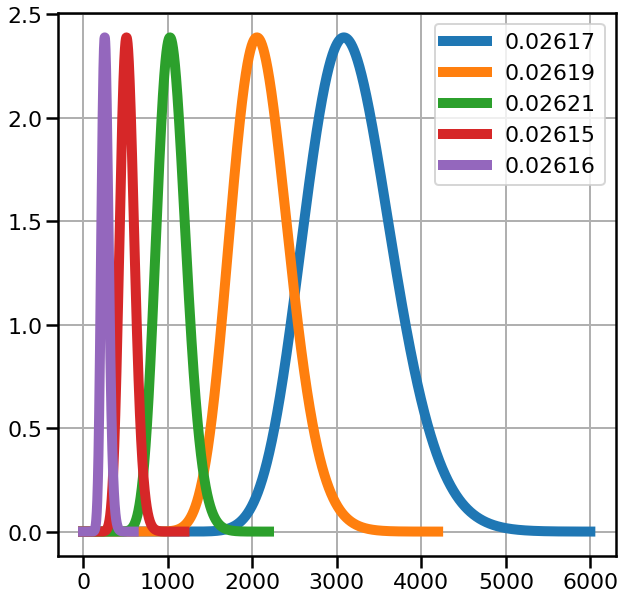

In [46]:
fig = plt.figure(figsize=(10,10))
params = [[3000.0, 6000.0, 400], 
           [2000.0, 4200.0, 384], 
           [1000.0, 2200.0, 357],
           [500.0, 1200.0, 331],
           [250.0, 600.0, 304],]
cs = []
for p in params:
    sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=p[0], buff_max=p[1],
           dt=1, ntau=p[2], k=35, g=1.0, ttype=ttype, 
           channels=20, kernel_width=23, dilation=2,
           dropout=None, batch_norm=None)

    ev1 = iSITH(tau_min=sp1['tau_min'], tau_max=sp1['tau_max'], buff_max=sp1['buff_max'], 
               k=sp1['k'], ntau=sp1['ntau'], dt=sp1['dt'], g=sp1['g'])
    cs.append("{:.5f}".format(ev1.c))
    #plt.plot(ev1.tau_star)
    plt.plot(ev1.filters[:, 0, 0, :, ].detach().cpu().T.numpy()[::-1, -1], linewidth=10
       );
    
plt.legend(cs)
for mn in mean_list:
    plt.axvline(mn, linewidth=2, color='purple', linestyle='--')
plt.grid()

In [40]:
cs

['0.02617', '0.02619', '0.02621', '0.02615', '0.02616']

0.01862899024468745 0.01862553402338607 0.019941201913632023


Text(0.5, 0, 'taustar index')

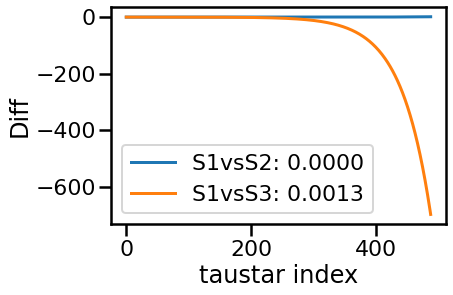

In [172]:
plt.plot(ev1.tau_star[:ev2.tau_star.shape[0]]-ev2.tau_star)
plt.plot(ev1.tau_star[:ev3.tau_star.shape[0]]-ev3.tau_star)
print(ev1.c, ev2.c, ev3.c)
plt.legend(['S1vsS2: {:.4f}'.format(abs(ev1.c - ev2.c)),
            'S1vsS3: {:.4f}'.format(abs(ev1.c - ev3.c))])
plt.ylabel("Diff")
plt.xlabel("taustar index")

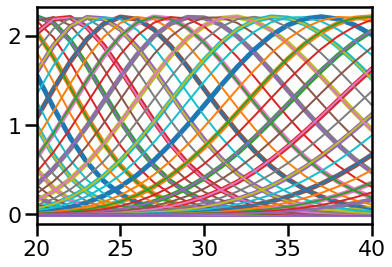

In [168]:
params = [[1000.0, 2000.0, 500], 
           [800.0, 1600.0, 488], 
           [600.0, 1200.0, 472],
           [400.0, 800.0, 451],
           [200.0, 400.0, 413],]
p = params[0]
sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=p[0], buff_max=p[1],
           dt=1, ntau=p[2], k=30, g=1.0, ttype=ttype, 
           channels=25, kernel_width=20, dilation=3,
           dropout=None, batch_norm=None)

ev1 = iSITH(tau_min=sp1['tau_min'], tau_max=sp1['tau_max'], buff_max=sp1['tau_max']*3, 
           k=sp1['k'], ntau=sp1['ntau'], dt=sp1['dt'], g=sp1['g'])
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1),
#        linewidth=8, color='grey');
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
#        linewidth=8, color='black');
plt.plot(ev1.filters[:, 0, 0, :, ].detach().cpu().T.numpy()[::-1, ::4], linewidth=5
       );


p = params[1]
sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=p[0], buff_max=p[1],
           dt=1, ntau=p[2], k=30, g=1.0, ttype=ttype, 
           channels=25, kernel_width=20, dilation=3,
           dropout=None, batch_norm=None)

ev2 = iSITH(tau_min=sp1['tau_min'], tau_max=sp1['tau_max'], buff_max=sp1['tau_max']*3, 
           k=sp1['k'], ntau=sp1['ntau'], dt=sp1['dt'], g=sp1['g'])
plt.plot(ev2.filters[:, 0, 0, :, ].detach().cpu().T.numpy()[::-1, 250:350:2], linewidth=2
       );
#plt.ylim(-.05, 2.1)
plt.xlim(20, 40)


sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=1500, buff_max=p[1],
           dt=1, ntau=p[2], k=30, g=1.0, ttype=ttype, 
           channels=25, kernel_width=20, dilation=3,
           dropout=None, batch_norm=None)

ev3 = iSITH(tau_min=sp1['tau_min'], tau_max=sp1['tau_max'], buff_max=sp1['tau_max']*3, 
           k=sp1['k'], ntau=sp1['ntau'], dt=sp1['dt'], g=sp1['g'])
#plt.legend(["Total Sum", "Alternating Sum"])

In [ ]:
plt.plot(ev1.tau_star[:ev2.tau_star.shape[0]]-ev2.tau_star)
plt.plot(ev1.tau_star[:ev3.tau_star.shape[0]]-ev3.tau_star)


# Go!

In [55]:
params = [[3000.0, 6000.0, 400], 
           [2000.0, 4200.0, 384], 
           [1000.0, 2200.0, 357],
           [500.0, 1200.0, 331],
           [250.0, 600.0, 304],]

In [89]:
for i, p in enumerate(params[1:2]):
    model = gen_model(p)
    
    tot_weights = 0
    for p in model.parameters():
        tot_weights += p.numel()
    print("Total Weights:", tot_weights)
    
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    epochs = 1200
    Trainscale = 10
    device='cuda'
    progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
    epochperfs = []
    times_100 = 0
    for epoch_idx in progress_bar:
        perfs = []
        losses = []
        model.train()
        for batch_idx, iv in enumerate(X):
            iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
            iv = iv.unsqueeze(-1)
            iv = iv.repeat(1,1,1,1,Trainscale)
            iv = iv.reshape(1,1,1,-1)
            tv = Y[batch_idx].to(device)
            optimizer.zero_grad()
            out = model(iv)
            loss = loss_func(out[:, -1, :],
                             torch.cuda.LongTensor([tv]))
            loss.backward()
            optimizer.step()

            perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                          tv).sum().item())
            #perfs = perfs[int(-loss_buffer_size/batch_size):]
            losses.append(loss.detach().cpu().numpy())
            #losses = losses[int(-loss_buffer_size/batch_size):]


            s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
            format_list = [epoch_idx, batch_idx, np.mean(losses), 
                           np.sum(perfs)/((len(perfs)))]
            s = s.format(*format_list)
            progress_bar.set_description(s)
            epochperfs.append(format_list)
        if (np.sum(perfs)/((len(perfs))) == 1.0) & (np.mean(losses) < .11):
            times_100 += 1
            if times_100 >= 3:
                break
    outcome = test_model(model, X, Y)
    torch.save(model.state_dict(), 'SITHCon_MORSE_ctaumax_new_{:02}.pt'.format(1))
    save_outcome(outcome, filename='SITHCon_MORSE_ctaumax_new_{:02}.csv'.format(1))


Total Weights: 21083


In [97]:
outcome = test_model(model, X, Y)
print(outcome)
save_outcome(outcome, filename='SITHCon_MORSE_ctaumax_{:02}.csv'.format(0))

{'test_perf': [0.11627906976744186, 0.32558139534883723, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9767441860465116, 0.9534883720930233, 0.813953488372093], 'rate': [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40], 'tau_max': [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], 'ntau': [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]}


In [98]:
dat1 = pd.read_csv(join('perf','SITHCon_MORSE_ctaumax_{:02}.csv'.format(0)))
print(dat1)
dat2 = pd.read_csv(join('perf','DeepSITH_morse_perf.csv'))
dat2

    Unnamed: 0  test_perf  rate  tau_max  ntau
0            0   0.116279     1   1000.0   500
1            1   0.325581     2   1000.0   500
2            2   1.000000     5   1000.0   500
3            3   1.000000     6   1000.0   500
4            4   1.000000     7   1000.0   500
5            5   1.000000     8   1000.0   500
6            6   1.000000     9   1000.0   500
7            7   1.000000    10   1000.0   500
8            8   1.000000    11   1000.0   500
9            9   1.000000    12   1000.0   500
10          10   1.000000    13   1000.0   500
11          11   1.000000    14   1000.0   500
12          12   1.000000    15   1000.0   500
13          13   1.000000    16   1000.0   500
14          14   1.000000    17   1000.0   500
15          15   1.000000    18   1000.0   500
16          16   1.000000    19   1000.0   500
17          17   0.976744    20   1000.0   500
18          18   0.953488    30   1000.0   500
19          19   0.813953    40   1000.0   500


Unnamed: 0  test_perf  rate
0            0   0.000000     1
1            1   0.023256     2
2            2   0.023256     5
3            3   0.023256     6
4            4   0.046512     7
5            5   0.093023     8
6            6   0.534884     9
7            7   1.000000    10
8            8   0.465116    11
9            9   0.093023    12
10          10   0.069767    13
11          11   0.023256    14
12          12   0.023256    15
13          13   0.023256    16
14          14   0.023256    17
15          15   0.023256    18
16          16   0.023256    19
17          17   0.046512    20
18          18   0.023256    30
19          19   0.023256    40

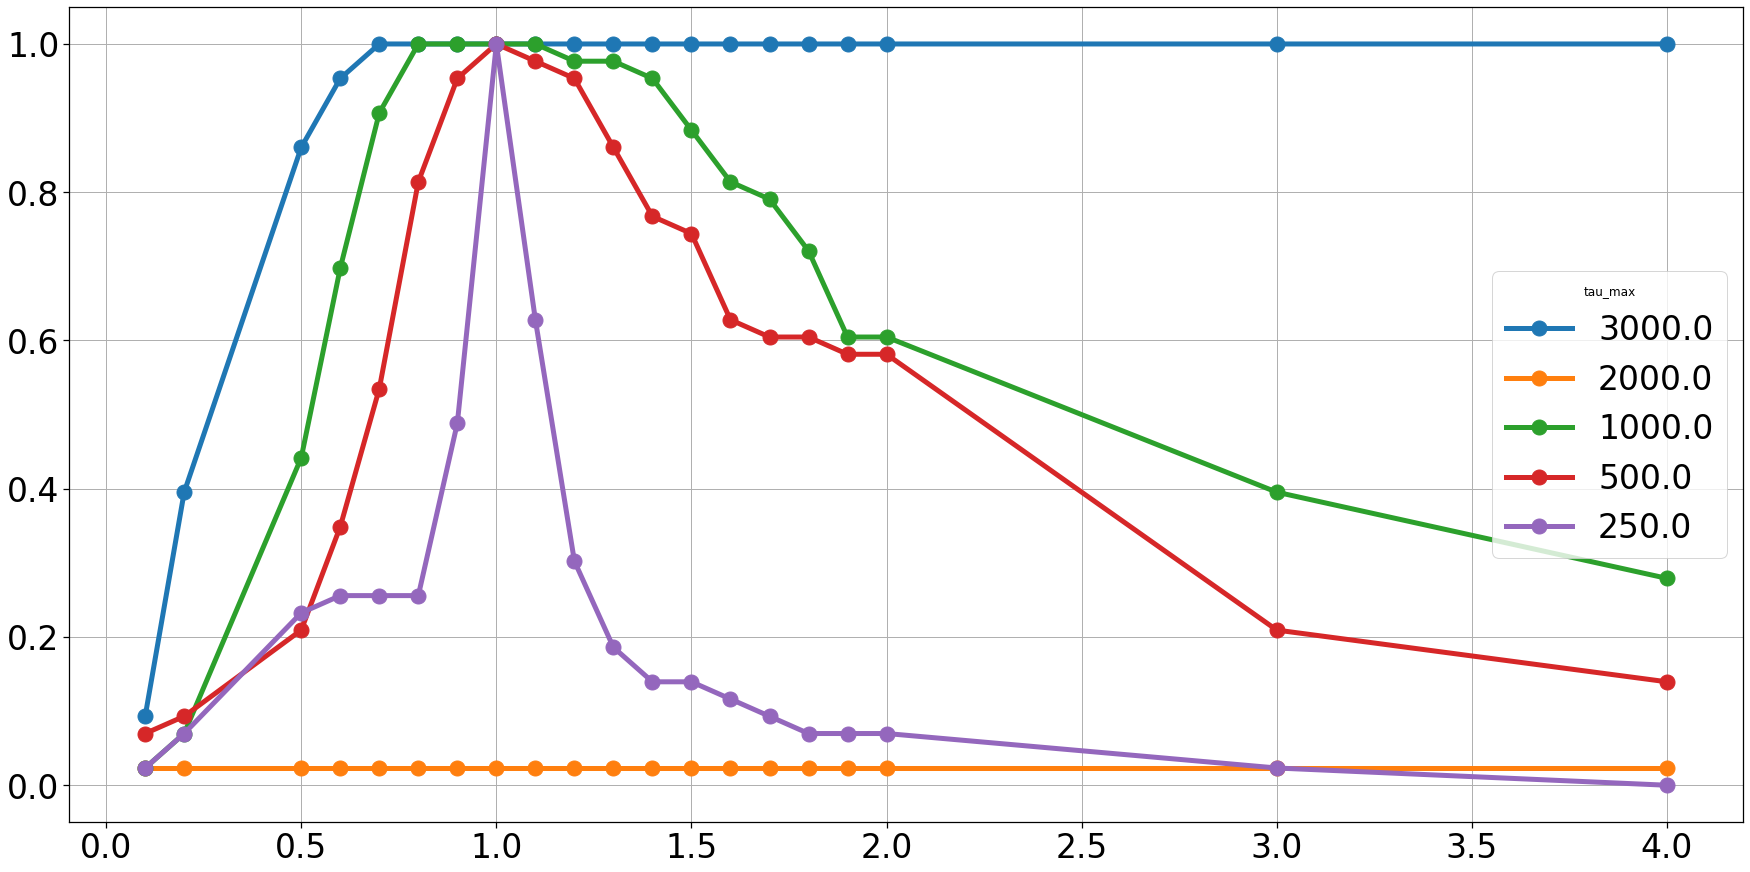

In [88]:
window_size = 20
lw=5
ms = 15
with sn.plotting_context("notebook", font_scale=3):
    fig=plt.figure(figsize=(30,15))
    Trainscale = 10
    taumaxes=[]
    for i in range(5):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_ctaumax_new_{:02}.csv'.format(i)))
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        taumaxes.append(dat1.tau_max[0])
    plt.legend(taumaxes, title='tau_max')
    plt.grid()
plt.savefig(join('figs', 'MORSE_TAUMAX_SITHCON_EDGE.png'))

In [ ]:
SITHCon_MORSE_ctaumax_new_{:02}.csv

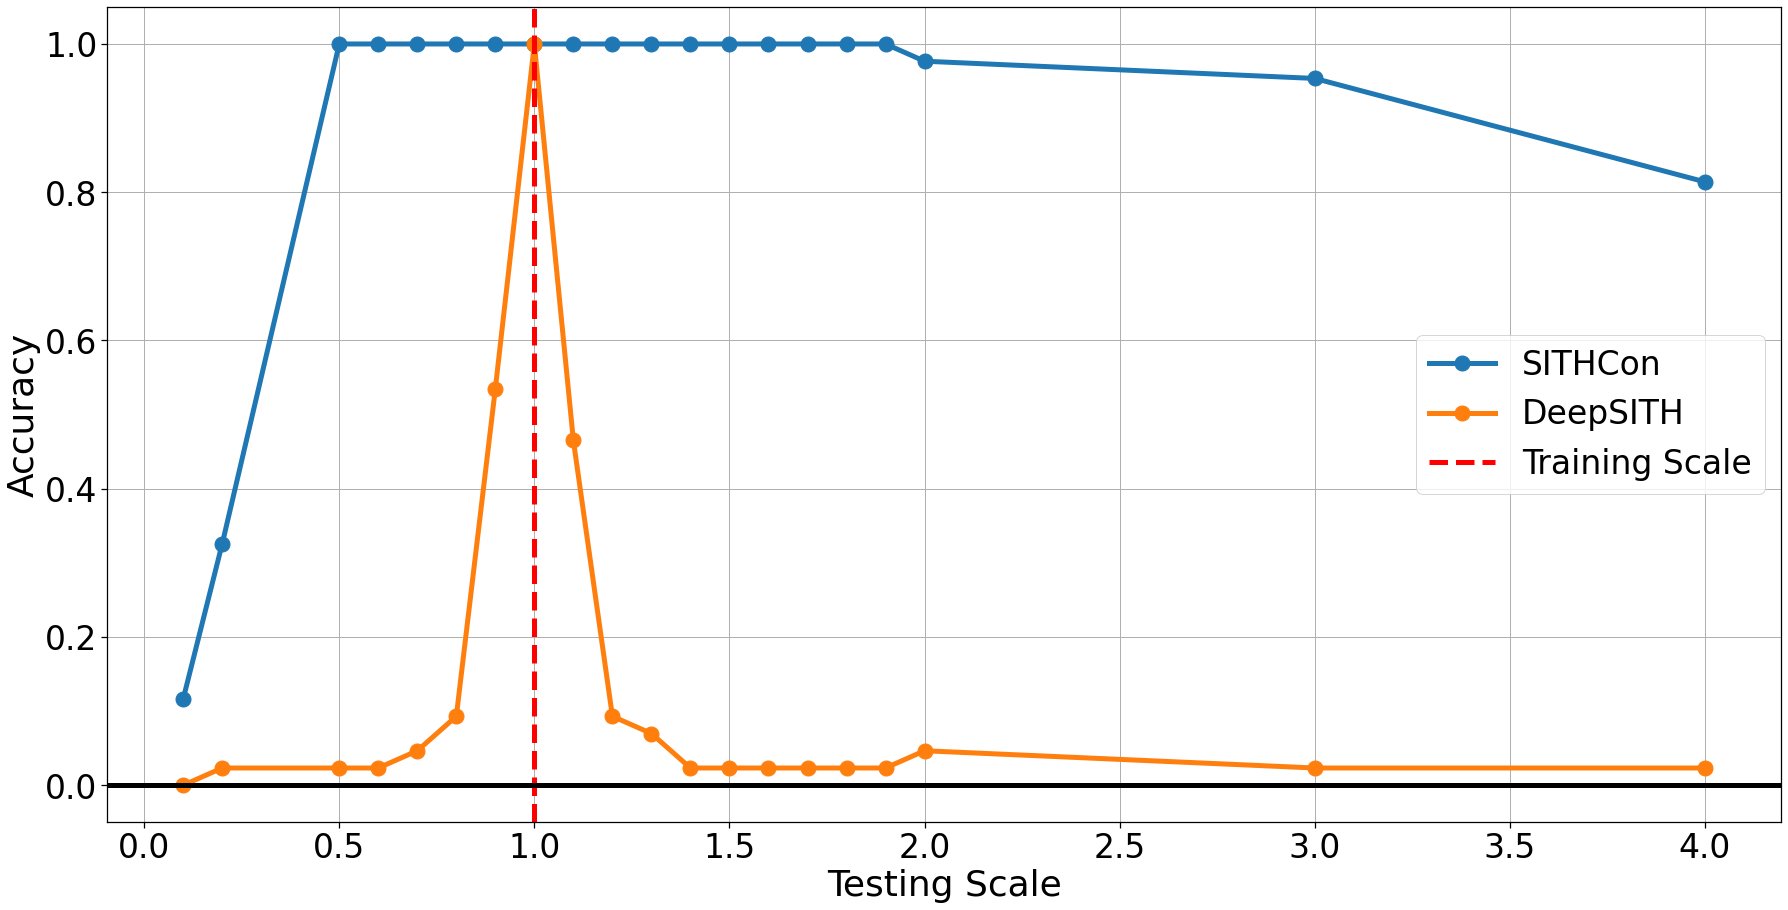

In [99]:
window_size = 20
lw=5
ms = 15
with sn.plotting_context("notebook", font_scale=3):
    fig=plt.figure(figsize=(30,15))
    Trainscale = 10
    plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
            linewidth=lw, ms=ms)
    plt.plot(dat2.rate/Trainscale, dat2.test_perf, marker='o',
            linewidth=lw, ms=ms)
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend(['SITHCon', 'DeepSITH', 'Training Scale'])
plt.savefig(join('figs', 'perf3layers'), dpi=100)

In [ ]:
window_size = 20
lw=5
ms = 15
with sn.plotting_context("notebook", font_scale=3):
    
    fig=plt.figure(figsize=(30,15))
    Trainscale = 10
    for i in range(5):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_ctaumax_{:02}.csv'.format(i)))
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend([1000, 800, 600, 400, 200])
plt.savefig(join('figs', 'perf3layers_tau_max_diff'), dpi=100)

In [30]:
import scipy.optimize as opt
from deepsith import iSITH
def min_fun(x, *args):
    ntau = args[2]
    k = int(x[0])
    if k < 4 or k>125:
        return np.inf
    tau_min = args[0]
    tau_max = args[1]    
    ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*5, k=k, ntau=ntau, dt=1, g=1.0)    
    std_0 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1)[int(tau_min):int(tau_max)].std()
    std_1 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1)[int(tau_min):int(tau_max)].std()    
    to_min = std_0/std_1
    return to_min

In [ ]:
ntau = 250
k_0 = 20
tau_min = .1
tau_max = 1000.
res = opt.minimize(min_fun, [k_0], args=(tau_min, tau_max, ntau), 
                   #method='Nelder-Mead',
                   method='Powell',
                   #method='L-BFGS-B',
                   #method='BFGS',
                   #method='CG',
                   #method='TNC',
                   bounds=[(4, 125)]
                  )
print(res)

k = int(res.x)
fig = plt.figure(figsize=(12,8))

print('ntau:', ntau, 'k:', k)

(-5.0, 3000.0)

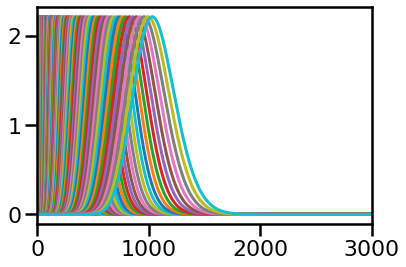

In [40]:
class SITHCon_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(SITHCon_Classifier, self).__init__()
        last_channels = layer_params[-1]['channels']
        self.transform_linears = nn.ModuleList([nn.Linear(l['channels'], l['channels'])
                                                for l in layer_params])
        self.sithcon_layers = nn.ModuleList([SITHCon_Layer(l, act_func) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
        
    def forward(self, inp):
        
        x = inp
        #out = []
        for i in range(len(self.sithcon_layers)):
            x = self.sithcon_layers[i](x)
            
            x = self.transform_linears[i](x[:,0,:,:].transpose(1,2))
            x = x.unsqueeze(1).transpose(2,3)

            #out.append(x.clone())
        x = x.transpose(2,3)[:, 0, :, :]
        #x = x.transpose(2,3)[:, 0, :, :]
        x = self.to_out(x)
        return x


torch.Size([1, 1, 1, 140])
torch.Size([1, 1, 1, 280])


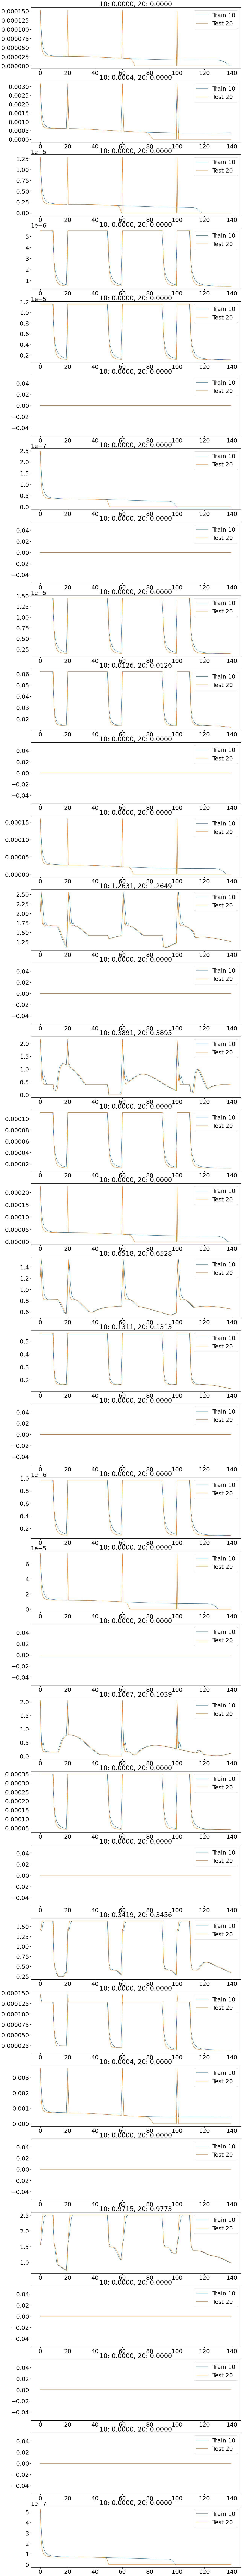

In [102]:
linew = 4
view_channel = 4
view_times = [-1, -1]
view_letter = 15
Testscale = 20
relu = nn.ReLU()
with sn.plotting_context("notebook", font_scale=2.8):
    fig = plt.figure(figsize=(20,250), )
    spec = gridspec.GridSpec(nrows=35, ncols=1,
                             figure=fig)
    
    
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Trainscale)
    inp = inp.reshape(1,1,1,-1)
    print(inp.shape)
    out = model.sithcon_layers[0].sithcon.sith(inp)
    out = out.transpose(3,1)
    scout1 = relu(model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3])))
        
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Testscale)
    inp = inp.reshape(1,1,1,-1)
    print(inp.shape)
    out = model.sithcon_layers[0].sithcon.sith(inp)
    out = out.transpose(3,1)
    scout2 = relu(model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3])))

    for c in range(35):
        ax = fig.add_subplot(spec[c, 0])
        ax.plot(np.arange(0, scout1.shape[0]), scout1[:, c, 0, :].detach().cpu().T.max(0)[0]);
        
        ax.plot(np.arange(0, scout1.shape[0], (Trainscale/Testscale)), scout2[:, c, 0, :].detach().cpu().T.max(0)[0]);
        ax.legend(["Train {}".format(Trainscale), "Test {}".format(Testscale)])
        ax.set_title("{}: {:.4f}, {}: {:.4f}".format(Trainscale, scout1[view_times[0], c, 0, :].detach().cpu().T.max(),
                                                     Testscale, scout2[view_times[1], c, 0, :].detach().cpu().T.max()))
#plt.savefig(join('figs', 'l1_chan_output_1000ntau_morekernelweights.png'), dpi=100)

torch.Size([1, 1, 1, 140])
torch.Size([1, 1, 1, 560])


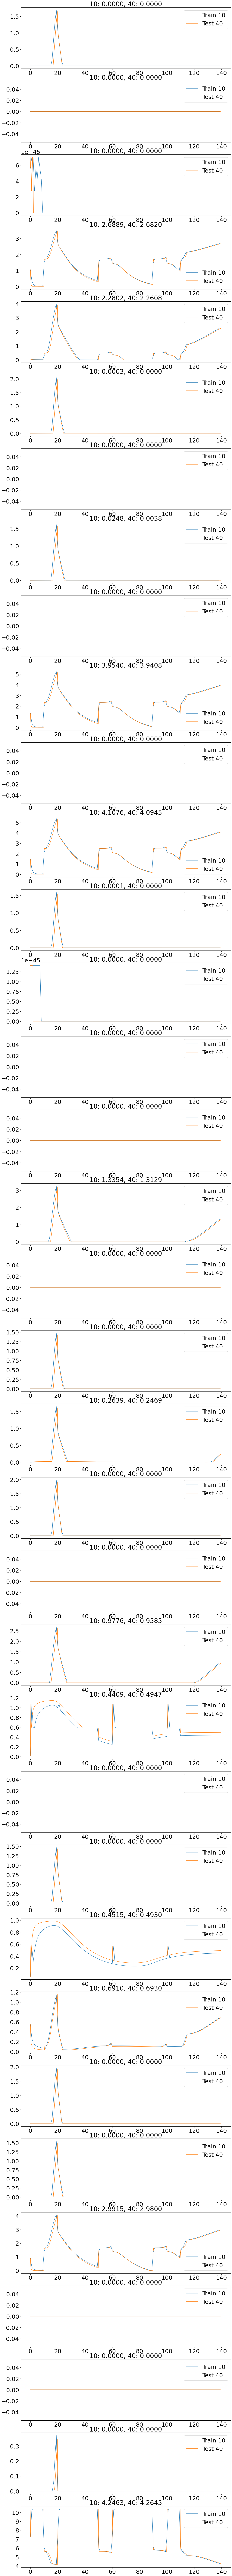

In [57]:
linew = 4
view_channel = 4
view_times = [-1, -1]
view_letter = 15
Testscale = 40
relu = nn.ReLU()
with sn.plotting_context("notebook", font_scale=2.8):
    fig = plt.figure(figsize=(20,250), )
    spec = gridspec.GridSpec(nrows=35, ncols=1,
                             figure=fig)
    
    
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Trainscale)
    inp = inp.reshape(1,1,1,-1)
    print(inp.shape)
    # Layer 1:
    x = model.sithcon_layers[0](inp)
    x = model.transform_linears[0](x[:,0,:,:].transpose(1,2))
    x = x.unsqueeze(1).transpose(2,3)
    # Layer 2:
    out = model.sithcon_layers[1].sithcon.sith(x)
    out = out.transpose(3,1)
    scout1 = relu(model.sithcon_layers[1].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3])))
        
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Testscale)
    inp = inp.reshape(1,1,1,-1)
    print(inp.shape)
    x = model.sithcon_layers[0](inp)
    x = model.transform_linears[0](x[:,0,:,:].transpose(1,2))
    x = x.unsqueeze(1).transpose(2,3)
    out = model.sithcon_layers[1].sithcon.sith(x)
    out = out.transpose(3,1)
    scout2 = relu(model.sithcon_layers[1].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3])))

    for c in range(scout1.shape[1]):
        ax = fig.add_subplot(spec[c, 0])
        ax.plot(np.arange(0, scout1.shape[0]), scout1[:, c, 0, :].detach().cpu().T.max(0)[0]);
        
        ax.plot(np.arange(0, scout1.shape[0], (Trainscale/Testscale)), scout2[:, c, 0, :].detach().cpu().T.max(0)[0]);
        ax.legend(["Train {}".format(Trainscale), "Test {}".format(Testscale)])
        ax.set_title("{}: {:.4f}, {}: {:.4f}".format(Trainscale, scout1[view_times[0], c, 0, :].detach().cpu().T.max(),
                                                     Testscale, scout2[view_times[1], c, 0, :].detach().cpu().T.max()))
plt.savefig(join('figs', 'l2_chan_output_1000ntau_morekernelweights.png'), dpi=100)

torch.Size([1, 1, 1, 140])
torch.Size([1, 1, 1, 280])


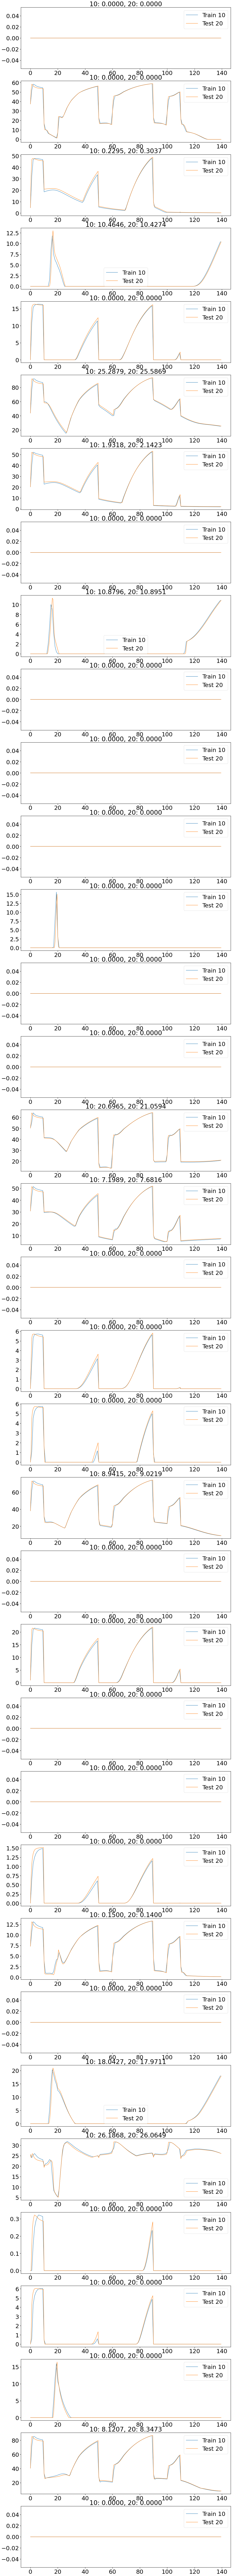

In [56]:
linew = 4
view_channel = 4
view_times = [-1, -1]
view_letter = 15
Testscale = 20
relu = nn.ReLU()
with sn.plotting_context("notebook", font_scale=2.8):
    fig = plt.figure(figsize=(20,250), )
    spec = gridspec.GridSpec(nrows=35, ncols=1,
                             figure=fig)
    
    
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Trainscale)
    inp = inp.reshape(1,1,1,-1)
    print(inp.shape)
    # Layer 1:
    x = model.sithcon_layers[0](inp)
    x = model.transform_linears[0](x[:,0,:,:].transpose(1,2))
    x = x.unsqueeze(1).transpose(2,3)
    # Layer 2: 
    x = model.sithcon_layers[1](x)
    x = model.transform_linears[1](x[:,0,:,:].transpose(1,2))
    x = x.unsqueeze(1).transpose(2,3)
    # Layer 3:
    out = model.sithcon_layers[2].sithcon.sith(x)
    out = out.transpose(3,1)
    scout1 = relu(model.sithcon_layers[2].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3])))
        
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Testscale)
    inp = inp.reshape(1,1,1,-1)
    print(inp.shape)
    # Layer 1:
    x = model.sithcon_layers[0](inp)
    x = model.transform_linears[0](x[:,0,:,:].transpose(1,2))
    x = x.unsqueeze(1).transpose(2,3)
    # Layer 2: 
    x = model.sithcon_layers[1](x)
    x = model.transform_linears[1](x[:,0,:,:].transpose(1,2))
    x = x.unsqueeze(1).transpose(2,3)
    # Layer 3:
    out = model.sithcon_layers[2].sithcon.sith(x)
    out = out.transpose(3,1)
    scout2 = relu(model.sithcon_layers[2].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3])))
        
    for c in range(35):
        ax = fig.add_subplot(spec[c, 0])
        ax.plot(np.arange(0, scout1.shape[0]), scout1[:, c, 0, :].detach().cpu().T.max(0)[0]);
        
        ax.plot(np.arange(0, scout1.shape[0], (Trainscale/Testscale)), scout2[:, c, 0, :].detach().cpu().T.max(0)[0]);
        ax.legend(["Train {}".format(Trainscale), "Test {}".format(Testscale)])
        ax.set_title("{}: {:.4f}, {}: {:.4f}".format(Trainscale, scout1[view_times[0], c, 0, :].detach().cpu().T.max(),
                                                     Testscale, scout2[view_times[1], c, 0, :].detach().cpu().T.max()))
plt.savefig(join('figs', 'l3_chan_output_1000ntau_morekernelweights.png'), dpi=100)

In [33]:
(1+model.sithcon_layers[2].sithcon.sith.c)

103.12831606721848

# Conclusions
## Morse Decoder
- The adding problem Def need more than one layer of SITHCon. It never learns. 
- increasing the number of tau SEEMS to reduce the differences in the outputs of the SITHCon layers through time at the two different scales.
- The size of the kernel is VERY important. If it isn't wide enough, or too wide, it seems to not scale as well.

## Morse Adding
- It is difficult to test any of these theories on ANY of these things in Morse Adding because the gradient seems to eat up all of my memory. 